# MNIST Digit Classification
Author: Gorachand Mondal
<br>GitHub: https://github.com/Gorachand2501/mnist-digit-classifier

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load and Transform MNIST Data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.22MB/s]


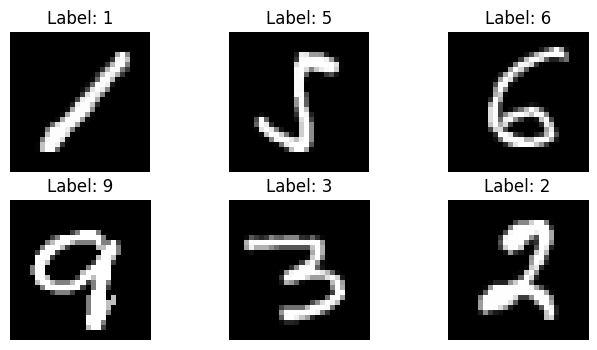

In [4]:
# Visualize Sample Data
def show_sample():
    images, labels = next(iter(train_loader))
    plt.figure(figsize=(8, 4))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

show_sample()

In [5]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)        # (28x28) → (26x26)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)       # (26x26) → (24x24)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)            # 64×12×12 = 9216
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # [64, 32, 26, 26]
        x = F.relu(self.conv2(x))       # [64, 64, 24, 24]
        x = F.max_pool2d(x, 2)          # [64, 64, 12, 12]
        x = self.dropout1(x)
        x = torch.flatten(x, 1)         # [64, 9216]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)                 # [64, 10]
        return x

model = CNN().to(device)


In [6]:
# Set Up Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Train with loss recording for CNN
epochs = 5
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.1944
Epoch 2/5, Loss: 0.0819
Epoch 3/5, Loss: 0.0606
Epoch 4/5, Loss: 0.0515
Epoch 5/5, Loss: 0.0458


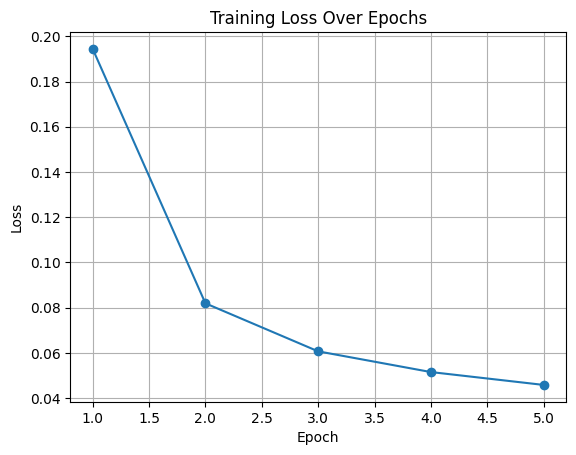

In [8]:
# Plot Training Loss
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

In [9]:
# Evaluate
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.08%


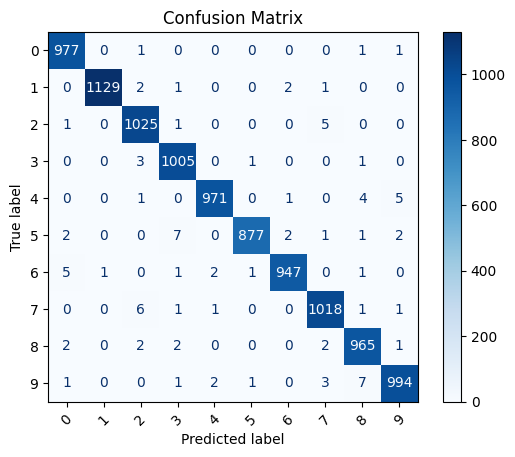

In [10]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Save the Trained Model
torch.save(model.state_dict(), "mnist_model.pth")
print("Model saved as mnist_model.pth")

Model saved as mnist_model.pth
